In [ ]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='nVO0l-ui8MblRQ0E8KUbP3__nzzX_yCIJnUI_oBJGTRh',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.au-syd.cloud-object-storage.appdomain.cloud')

bucket = 'telelawdisparitiesanalysis-donotdelete-pr-bmiceg71raiki8'
object_key = 'DistrictswiseCR_AEdataf_24-25.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)


Geopandas is already installed.

--- Initial Data Inspection ---
Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     1572 non-null   object
 1   states_ut_s  1572 non-null   object
 2   districts    1572 non-null   object
 3   no__of_cscs  1572 non-null   int64 
 4   female       1572 non-null   int64 
 5   male         1572 non-null   int64 
 6   total        1572 non-null   int64 
 7   general      1572 non-null   int64 
 8   obc          1572 non-null   int64 
 9   sc           1572 non-null   int64 
 10  st           1572 non-null   int64 
 11  total_1      1572 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 147.5+ KB

First 5 rows of the dataset:
          category          states_ut_s                 districts  \
0  Case Registered  Andaman and Nicobar                   Nicobar   
1  Ca

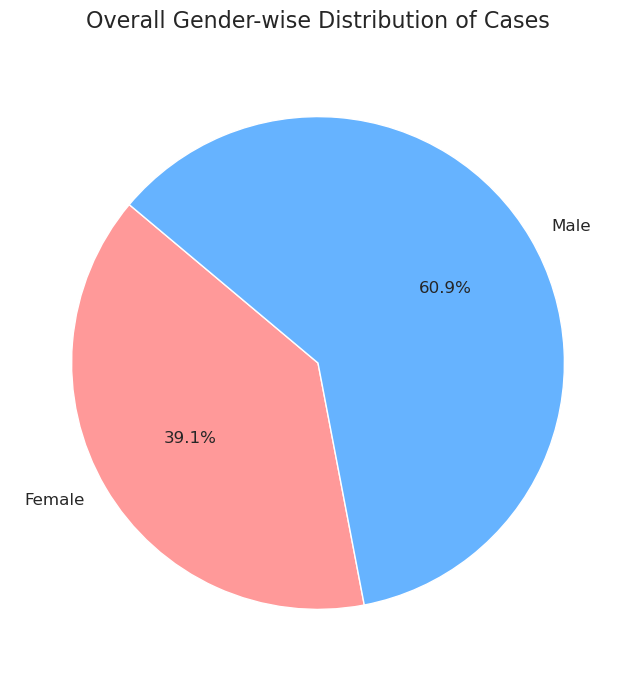

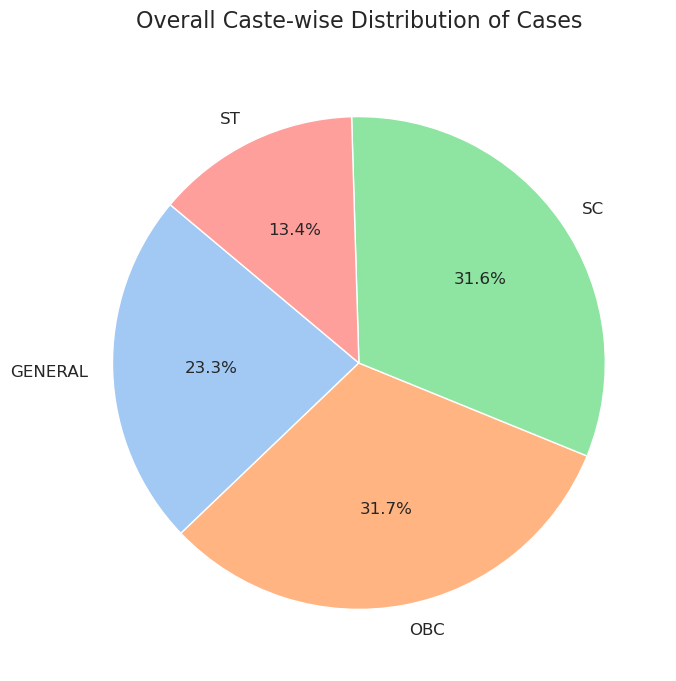

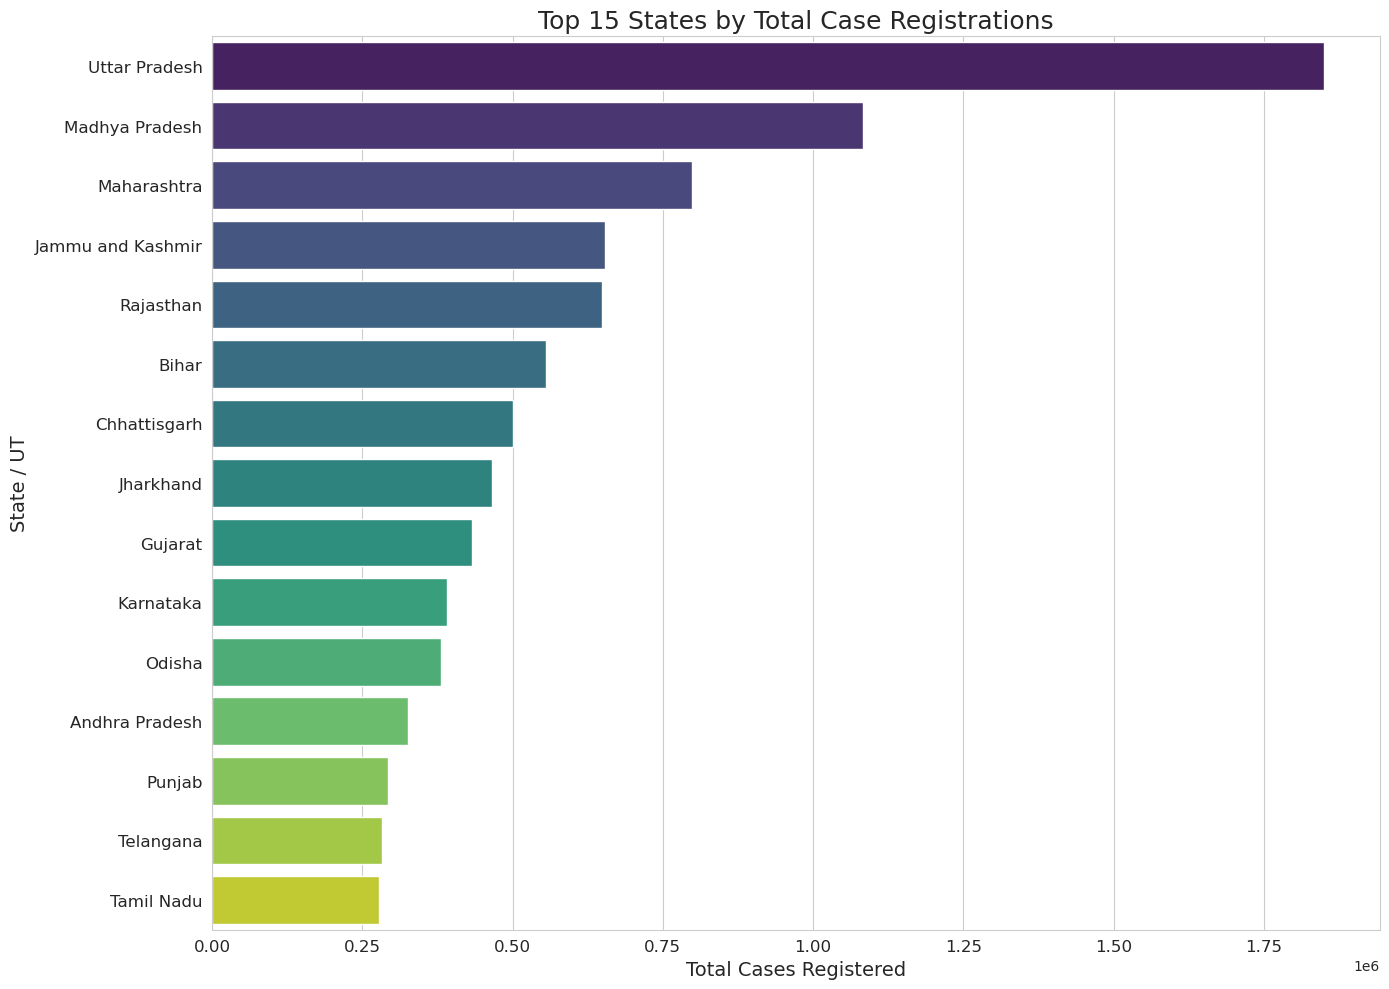


--- Generating Indian Map Visualization ---
India map data loaded successfully.


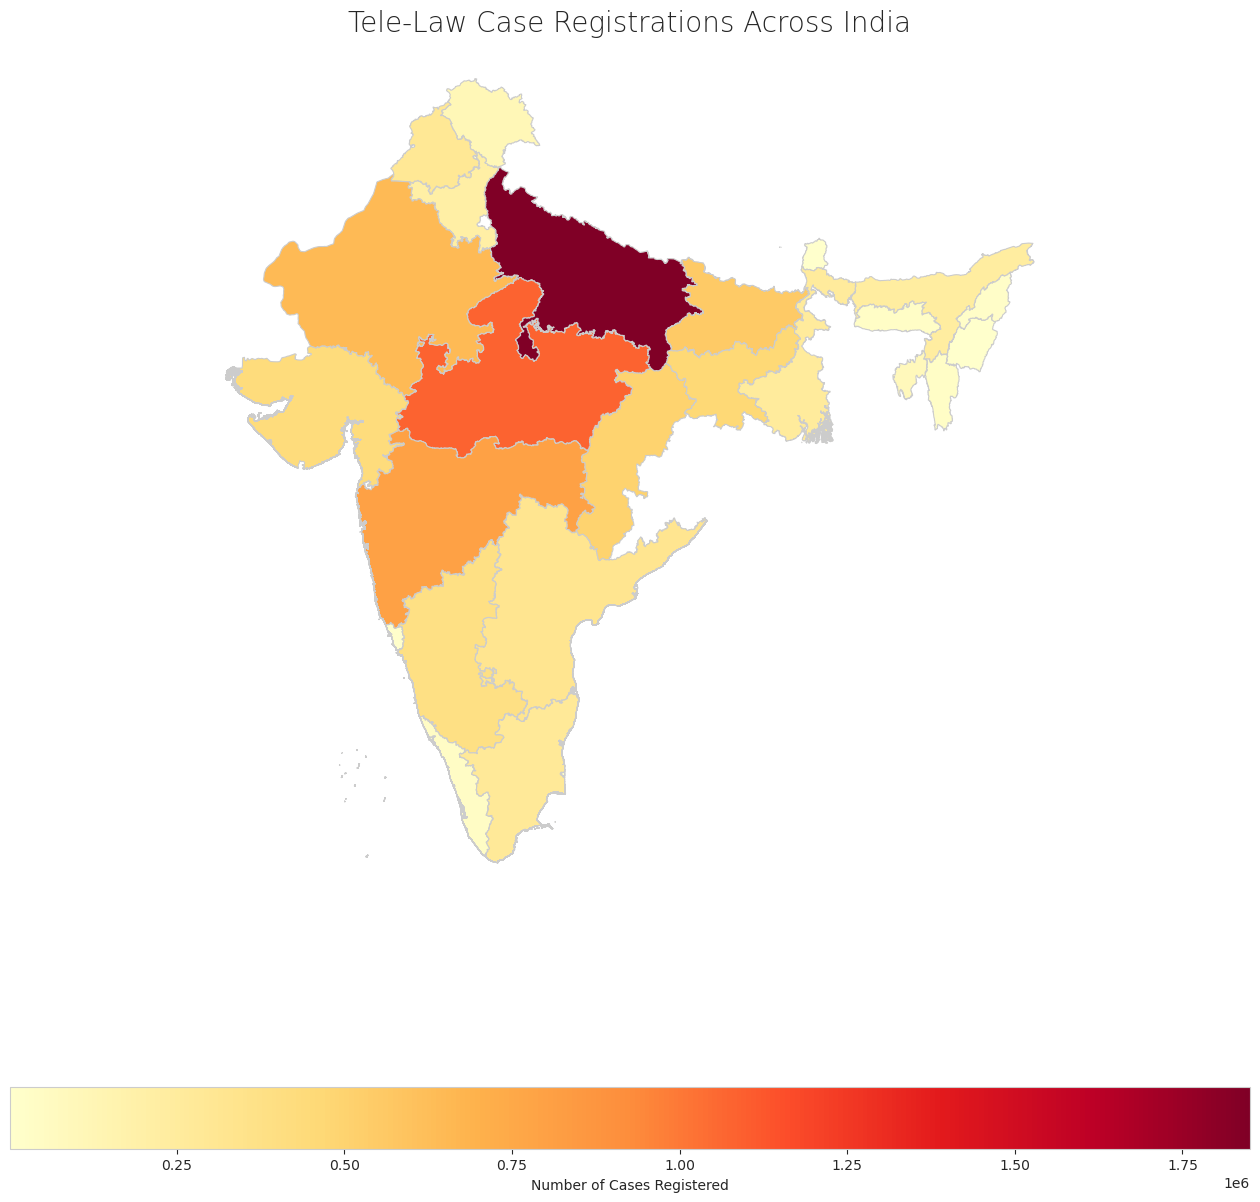


--- All Visualizations Generated ---


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import sys
import io

# --- 2. Install Geopandas for Mapping ---
# This will check if geopandas is installed and, if not, install it.
try:
    import geopandas as gpd
    print("Geopandas is already installed.")
except ImportError:
    print("Geopandas not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geopandas"])
    import geopandas as gpd
    print("Geopandas installed successfully.")


# --- 3. Load the Dataset from your Project Assets ---
#
# >>> IMPORTANT INSTRUCTION TO FIX THE FileNotFoundError <<<
#
# 1. Make sure you have uploaded 'DistrictswiseCR_AEdataf_24-25.csv' as a data asset to your project.
# 2. Click in an empty cell in your notebook.
# 3. Find your data file in the 'Assets' pane (usually on the right-hand side).
# 4. Click 'Insert to code' or 'Insert pandas DataFrame'. This will generate new code in the cell
#    that loads your data. It will create a DataFrame, probably named 'df_data_1'.
# 5. Add the following line in that same cell to copy the data into the `df` variable that this script uses:
#
#    df = df_data_1.copy()
#
# 6. Run that cell to load the data, and then you can run the rest of this script.
#
# PLEASE PERFORM THE STEPS ABOVE BEFORE PROCEEDING. The script will not work without the 'df' DataFrame.
#
# For demonstration purposes, the script will try to continue, but it will fail if 'df' is not loaded.


# --- Initial Data Inspection ---
# This block will now only run if you have successfully loaded 'df' in a cell above.
if 'df' not in locals():
    print("Error: The DataFrame 'df' has not been loaded.")
    print("Please follow the instructions in Step 3 to load your data before running the rest of the script.")
    sys.exit() # Stop execution if the file is not found

print("\n--- Initial Data Inspection ---")
print("Dataset loaded successfully.")
# Use a string buffer to capture the info() output to print it cleanly
buffer = io.StringIO()
df.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

print("First 5 rows of the dataset:")
print(df.head())


# --- 4. Data Cleaning ---
# Standardize column names for easier access
original_columns = df.columns.tolist()
df.columns = df.columns.str.lower().str.replace('[^a-zA-Z0-9_]', '_', regex=True).str.replace('.', '_', regex=False)

print("\nCleaned column names:")
print(df.columns)

df = df.rename(columns={
    'states_ut_s': 'state_ut',
    'no__of_cscs': 'num_of_cscs',
    'total': 'total_cases_gender',
    'total_1': 'total_cases'
})

# Filter for 'Case Registered' category only, as the file contains other data
case_df = df[df['category'] == 'Case Registered'].copy()

print("\n--- Data after cleaning and preparation ---")
print(f"Total 'Case Registered' records: {len(case_df)}")
print(case_df.head())


# --- 5. Geographic Disparity Analysis ---
print("\n--- 3.1 Analyzing Geographic Disparities ---")
# Aggregate data by state
state_wise_analysis = case_df.groupby('state_ut').agg({
    'total_cases': 'sum',
    'num_of_cscs': 'sum'
}).reset_index()
# Calculate cases per CSC, handling potential division by zero
state_wise_analysis['cases_per_csc'] = state_wise_analysis.apply(
    lambda row: row['total_cases'] / row['num_of_cscs'] if row['num_of_cscs'] > 0 else 0, axis=1
)

# Sort by total cases to find the top states
state_wise_sorted = state_wise_analysis.sort_values(by='total_cases', ascending=False)

print("\nTop 10 States by Total Case Registrations:")
print(state_wise_sorted.head(10))


# --- 6. Gender-wise Disparity Analysis ---
print("\n\n-- 3.2 Analyzing Gender-wise Disparities ---")
gender_distribution = case_df[['female', 'male']].sum()
print(f"Overall Gender Distribution: Female={gender_distribution['female']}, Male={gender_distribution['male']}")


# --- 7. Caste-wise Disparity Analysis ---
print("\n\n--- 3.3 Analyzing Caste-wise Disparities ---")
caste_distribution = case_df[['general', 'obc', 'sc', 'st']].sum()
caste_df_printable = pd.DataFrame(caste_distribution, columns=['count']).reset_index().rename(columns={'index': 'caste'})

print("\nOverall Caste-wise Distribution:")
print(caste_df_printable)

# Calculate percentage of SC/ST cases
total_caste_cases = caste_distribution.sum()
sc_st_cases = caste_distribution['sc'] + caste_distribution['st']
sc_st_percentage = (sc_st_cases / total_caste_cases) * 100 if total_caste_cases > 0 else 0
print(f"\nPercentage of cases from SC/ST communities: {sc_st_percentage:.2f}%")


# --- 8. Concluding Statement ---
print("\n--- Analysis Complete ---")
print("The analysis reveals significant disparities in Tele-Law service utilization across different regions, genders, and social categories.")
print("Key findings can be used to inform policy and optimize service delivery for more inclusive legal access.")


# --- 9. Visualizations ---
print("\n--- Generating Visualizations ---")

# Gender Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(gender_distribution, labels=gender_distribution.index.str.capitalize(), autopct='%1.1f%%',
        startangle=140, colors=['#ff9999','#66b3ff'], textprops={'fontsize': 12})
plt.title('Overall Gender-wise Distribution of Cases', pad=20, fontsize=16)
plt.ylabel('')
plt.show()

# Caste Pie Chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette('pastel')[0:5]
plt.pie(caste_distribution, labels=caste_distribution.index.str.upper(), autopct='%1.1f%%',
        startangle=140, colors=colors, textprops={'fontsize': 12})
plt.title('Overall Caste-wise Distribution of Cases', pad=20, fontsize=16)
plt.ylabel('')
plt.show()

# Geographic Bar Chart
top_n = 15
plt.figure(figsize=(14, 10))
sns.barplot(x='total_cases', y='state_ut', data=state_wise_sorted.head(top_n), palette='viridis')
plt.title(f'Top {top_n} States by Total Case Registrations', fontsize=18)
plt.xlabel('Total Cases Registered', fontsize=14)
plt.ylabel('State / UT', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Geographic Map
print("\n--- Generating Indian Map Visualization ---")
state_cases_map = case_df.groupby('state_ut')['total_cases'].sum().reset_index()
geojson_url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_state.geojson"
try:
    india_map = gpd.read_file(geojson_url)
    print("India map data loaded successfully.")
except Exception as e:
    print(f"Could not download map data. Please check your internet connection. Error: {e}")
    sys.exit()

name_mapping = {
    'Andaman and Nicobar': 'Andaman and Nicobar Islands',
    'Jammu and Kashmir': 'Jammu & Kashmir',
    'Arunachal Pradesh': 'Arunanchal Pradesh',
    'Dadra and Nagar Haveli and Daman and Diu': 'Dadara & Nagar Havelli',
    'Delhi': 'NCT of Delhi'
}
state_cases_map['state_ut'] = state_cases_map['state_ut'].replace(name_mapping)

merged_map_data = india_map.set_index('NAME_1').join(state_cases_map.set_index('state_ut'))

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.set_title('Tele-Law Case Registrations Across India', fontdict={'fontsize': '20', 'fontweight': '5'})
ax.axis('off')

merged_map_data.plot(column='total_cases', cmap='YlOrRd', linewidth=0.8, ax=ax,
                     edgecolor='0.8', legend=True,
                     legend_kwds={'label': "Number of Cases Registered", 'orientation': "horizontal"})
plt.show()

print("\n--- All Visualizations Generated ---")
